In [1]:
import numpy as np
import pandas as pd
import os

import dgl
import torch
import torch.nn as nn
from dgl.nn import GATv2Conv
import torch.nn.functional as F

from sklearn.metrics.pairwise import cosine_similarity

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
DATA_HOME = "/lyceum/jhk1c21/msc_project/data"
V14_PATH = os.path.join(DATA_HOME, "graph", "v14")
FILTERED_PATH = os.path.join(V14_PATH, "filtered")

In [3]:
# Load the data
nodes = pd.read_csv(os.path.join(V14_PATH, "nodes_v14.csv"), index_col='id')
similarity = pd.read_csv(os.path.join(FILTERED_PATH, "similarity_edges.csv"))

titles = np.load(os.path.join(FILTERED_PATH, 'title_embedding.npy'))
abstracts = np.load(os.path.join(FILTERED_PATH, 'abstract_embedding.npy'))
keywords = np.load(os.path.join(FILTERED_PATH, 'keywords_embedding.npy'))
domains = np.load(os.path.join(FILTERED_PATH, 'domains_embedding.npy'))

ids = np.load(os.path.join(FILTERED_PATH, "filtered_id.npy"))
edges = np.load(os.path.join(FILTERED_PATH, 'filtered_edge.npy'))

In [4]:
df = pd.DataFrame()
df['src'] = edges[:, 0]
df['dst'] = edges[:, 1]

# convert id from str to numbers
id_to_int = {original_id: i for i, original_id in enumerate(ids)}
int_to_id = {i: original_id for original_id, i in id_to_int.items()}

df['src'] = df['src'].apply(lambda x: id_to_int[x])
df['dst'] = df['dst'].apply(lambda x: id_to_int[x])

In [5]:
# Step 3: Create a graph using DGL
citation_network = dgl.graph((df['src'].to_numpy(), df['dst'].to_numpy()))
citation_network.ndata['features'] = torch.tensor(features, dtype=torch.float32)

NameError: name 'features' is not defined

In [26]:
# Step 4: Set up the GAT model
class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = GATv2Conv(in_dim, hidden_dim, num_heads=num_heads, allow_zero_in_degree=True)
        self.layer2 = GATv2Conv(hidden_dim * num_heads, out_dim, num_heads=1, allow_zero_in_degree=True)

    def forward(self, g, features):
        h = self.layer1(g, features).view(h.size(0), -1)
        h = F.elu(h)
        h = self.layer2(g, h).squeeze(1)
        return h

In [34]:
# Step 3: Create a function to compute similarity matrices for each feature
def compute_similarity_matrices(features):
    similarity_matrices = []
    for feature in features:
        sim_matrix = F.cosine_similarity(feature.unsqueeze(1), feature.unsqueeze(0), dim=2)
        similarity_matrices.append(sim_matrix)
    return similarity_matrices

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    # as output dimension is different
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
model = GAT(in_dim=1200, hidden_dim=100, out_dim=50, num_heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Step 6: Train the GAT model (simplified; implement a robust training loop)
for epoch in range(100):  # Adjust the number of epochs
    model.train() # train starts
    
    optimizer.zero_grad()
    criterion = ContrastiveLoss()
    
    output = model(citation_network, citation_network.ndata['features'])
    
    # Split the concatenated features back into individual features for similarity computations
    title_features = output[:, :300]
    keywords_features = output[:, 300:600]
    abstract_features = output[:, 600:900]
    domains_features = output[:, 900:]

    # Get similarity matrices for each feature
    features = [title_features, keywords_features, abstract_features]
    similarity_matrices = compute_similarity_matrices(features)
    domains_similarity_matrix = compute_similarity_matrix(domains_features)

    # Compute the loss
    loss = contrastive_loss(similarity_matrices, domains_similarity_matrix, margin=0.5)
    
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/100], Loss: {loss.item()}')


In [ ]:
# Step 7: Generate recommendations (simplified; implement a robust recommendation system)
def recommend_papers(node_id):
    model.eval()
    with torch.no_grad():
        node_representations = model(g, g.ndata['feature']).numpy()
    
    similarity_scores = cosine_similarity(node_representations, node_representations[node_id].reshape(1, -1))
    top5_indices = similarity_scores.argsort(axis=0)[-6:-1][::-1]  # Excluding the paper itself
    return top5_indices

# Get recommendations for a paper (replace 0 with a valid node ID)
recommendations = recommend_papers(0)
print(f'Top 5 recommendations for paper 0: {recommendations.flatten()}')


In [256]:
import torch
import numpy as np
import os
import torch.nn.functional as F

output_dir = '/lyceum/jhk1c21/msc_project/batch'
out = torch.load(os.path.join(output_dir, 'result_100_10k_05.pt'))

In [9]:
score = F.cosine_similarity(out[0], out[1])

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [68]:
score = F.cosine_similarity(out[0], out[1], dim=0)

In [69]:
# n_nodes = out.shape[0]
n_nodes = 1000

out_np = out.detach().numpy() 
i_indices, j_indices = np.triu_indices(n_nodes, k=1)
scores_np = cosine_similarity(out_np[i_indices], out_np[j_indices])
scores = list(zip(i_indices, j_indices, scores_np))

In [5]:
len(scores)

NameError: name 'scores' is not defined

In [51]:
# score = F.cosine_similarity(out[:10000], out[1:10001], dim=1)
score = F.cosine_similarity(out[:-1], out[1:], dim=1)

In [4]:
import numpy as np

i, j = np.triu_indices(4, k=1)
print(i)
print(j)

[0 0 0 1 1 2]
[1 2 3 2 3 3]


In [6]:
edges

NameError: name 'edges' is not defined

In [9]:
import torch
import os

In [6]:
output_dir = '/lyceum/jhk1c21/msc_project/batch'

# Load the data and move it to the appropriate device
out = torch.load(os.path.join(output_dir, 'result.pt'))

In [13]:
out.shape

torch.Size([162207, 50])

In [7]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity

DATA_HOME = "/lyceum/jhk1c21/msc_project/data"
V14_PATH = os.path.join(DATA_HOME, "graph", "v14")
FILTERED_PATH = os.path.join(V14_PATH, "filtered")
output_dir = '/lyceum/jhk1c21/msc_project/batch'


out_1000 = torch.load(os.path.join(output_dir, 'result_1000.pt'))
ids = np.load(os.path.join(FILTERED_PATH, "filtered_id.npy"))
edges = np.load(os.path.join(FILTERED_PATH, 'filtered_edge.npy'))


df = pd.DataFrame()
df['src'] = edges[:, 0]
df['dst'] = edges[:, 1]

# convert id from str to numbers
id_to_int = {original_id: i for i, original_id in enumerate(ids)}
int_to_id = {i: original_id for original_id, i in id_to_int.items()}

df['src'] = df['src'].apply(lambda x: id_to_int[x])
df['dst'] = df['dst'].apply(lambda x: id_to_int[x])

mean_for_normalise = {}
std_for_normalise = {}

title_similarity_list = []
abstract_similarity_list = []
keyword_similarity_list = []
domain_similarity_list = []

# normalise only in terms of edges
# src_list, dst_list = list(df['src']), list(df['dst'])
pairs = df.set_index(['src', 'dst']).index.to_numpy()

In [27]:
pairs = df.set_index(['src', 'dst']).index.to_numpy()

In [44]:
x, y = out[df.to_numpy()[:5,0]], out[df.to_numpy()[:5,1]]

In [48]:
cosine_similarity(torch.tensor(x), torch.tensor(y))

/tmp/ipykernel_97265/1214255165.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cosine_similarity(torch.tensor(x), torch.tensor(y))


array([[0.9848397 , 0.4211213 , 0.5245686 , 0.6455764 , 0.8509845 ],
       [0.3708132 , 0.95474565, 0.65809166, 0.39556172, 0.34735   ],
       [0.4042633 , 0.89693385, 0.7705052 , 0.46118852, 0.41575038],
       [0.45154044, 0.6089085 , 0.15610601, 0.32301834, 0.71218914],
       [0.8797461 , 0.33456242, 0.41329357, 0.6909531 , 0.97044975]],
      dtype=float32)

In [62]:
df = pd.read_csv(os.path.join(FILTERED_PATH, "trained_sim_1000.csv"))
df = pd.read_csv(os.path.join(FILTERED_PATH, "trained_sim.csv"))


In [13]:
ddf = pd.concat([df, similarity[['title', 'abstract', 'keyword', 'domain']]],axis=1)
ddf

,src,dst,sim,org_sim,diff,title,abstract,keyword,domain
0,14961,42725,0.969388,0.467984,0.501403,0.470632,0.124602,0.634944,0.445128
1,33767,141985,0.683254,0.464085,0.219169,0.363818,0.738057,0.825033,0.803241
2,64675,132132,0.690052,0.317569,0.372483,0.549633,0.203248,0.594433,0.879736
3,102146,98155,0.730458,0.460876,0.269582,0.600002,0.239508,0.842274,0.688702
4,118623,112343,0.709644,0.475699,0.233945,0.568734,0.682352,0.832233,0.852411
...,...,...,...,...,...,...,...,...,...
1273170,69751,63337,0.685944,0.312897,0.373047,0.684507,0.129349,0.513802,0.881588
1273171,65311,59922,0.779911,0.336277,0.443634,0.524307,0.402008,0.199441,0.722187
1273172,156811,12704,0.440018,0.384613,0.055405,0.499875,0.309166,0.822491,0.854233
1273173,155283,108435,0.231219,0.450320,-0.219101,0.525179,0.415119,0.722028,0.705364


In [118]:
df['org_sim'] = 0.2*similarity['title'] + 0.2*similarity['abstract'] + 0.2*similarity['keyword'] + 0.4*(1-similarity['domain'])

In [119]:
df['diff'] = df['sim'] - df['org_sim']
df

,src,dst,sim,org_sim,diff
0,14961,42725,0.979685,0.467984,0.511700
1,33767,141985,0.863072,0.464085,0.398987
2,64675,132132,0.887548,0.317569,0.569980
3,102146,98155,0.835505,0.460876,0.374629
4,118623,112343,0.966805,0.475699,0.491106
...,...,...,...,...,...
2546345,63337,69751,0.931651,NaN,NaN
2546346,59922,65311,0.978105,NaN,NaN
2546347,12704,156811,0.927909,NaN,NaN
2546348,108435,155283,0.902367,NaN,NaN


In [11]:
df[ (df['diff'] < 0.001) & (df['diff'] > -0.001)].sort_values('diff')
# 200949/df.shape[0]

,src,dst,sim,org_sim,diff
819434,59719,58507,0.460162,0.461153,-0.000991
636382,161132,8765,0.220231,0.221221,-0.000991
360547,126687,82463,0.436755,0.437745,-0.000990
84683,34157,64250,0.498095,0.499082,-0.000987
43913,125452,63967,0.437080,0.438067,-0.000987
...,...,...,...,...,...
412937,159820,14803,0.336606,0.335610,0.000995
432190,151201,57205,0.395892,0.394896,0.000996
600060,157785,95297,0.434161,0.433164,0.000997
1127214,13083,68769,0.566007,0.565008,0.000998


In [15]:
# ddf[ ddf['diff'] > 0].sort_values('org_sim', ascending=False)
ddf[ (ddf['diff'] >0) & (ddf['sim'] != 0)].sort_values('diff')
# pairs = df[ df['diff'] > 0].sort_values('diff', ascending=False)[['src', 'dst']].to_numpy()

,src,dst,sim,org_sim,diff,title,abstract,keyword,domain
117158,136757,585,0.294286,0.294284,0.000002,0.297683,0.201147,0.548176,0.787793
785427,149476,67076,0.276974,0.276972,0.000002,0.569136,0.055624,0.431231,0.835564
1023104,88169,86936,0.394607,0.394605,0.000002,0.545520,0.425649,0.686707,0.842425
965325,140481,15475,0.389839,0.389835,0.000004,0.625992,0.223907,0.470710,0.685716
604249,159107,58299,0.531053,0.531048,0.000005,0.832096,0.228625,0.837906,0.621693
...,...,...,...,...,...,...,...,...,...
953979,152428,552,0.988050,0.182893,0.805157,0.144460,0.132732,0.376662,0.869694
152089,39140,95304,0.985229,0.177196,0.808033,0.346514,0.116802,0.112345,0.844842
1017214,127077,1769,0.918570,0.106662,0.811908,0.153719,-0.043836,0.169255,0.872914
658264,8913,77588,0.999500,0.187060,0.812440,0.395869,0.254391,0.057004,0.885982


In [368]:
ddf[ddf['diff'] < 0].sort_values('diff', ascending=False)

,src,dst,sim,org_sim,diff,title,abstract,keyword,domain
804492,148907,150236,0.419840,0.419846,-0.000006,0.625785,0.448520,0.420719,0.697896
219627,122098,151647,0.423299,0.423309,-0.000010,0.464363,0.412059,0.617253,0.688566
697274,92190,73712,0.433062,0.433073,-0.000011,0.796437,0.512279,0.629136,0.886243
711794,118811,139114,0.494588,0.494602,-0.000015,0.771672,0.539791,0.861443,0.849947
519792,156974,74125,0.355709,0.355724,-0.000015,0.400157,0.440195,0.701352,0.881541
...,...,...,...,...,...,...,...,...,...
1033167,76872,25768,0.000000,0.752447,-0.752447,0.757638,0.756659,0.883071,0.317565
998488,21174,68434,0.000000,0.759098,-0.759098,0.713403,0.851763,0.879399,0.324536
432416,75077,98270,-0.276499,0.495920,-0.772419,0.558652,0.971358,0.521805,0.786108
529063,151864,33545,-0.143073,0.630573,-0.773646,0.762672,0.908175,0.480253,0.499117


In [366]:
nodes.loc[[int_to_id[4227], int_to_id[70959]]]

,title,keywords,abstract,fos
id,,,,
53e998dbb7602d9702117c3f,Aggregate Query Answering On Anonymized Tables,"['privacy', 'data privacy', 'databases', 'avai...",Privacy is a serious concern when microdata ne...,"[{'name': 'Data mining', 'w': 0.45358}, {'name..."
53e9ad99b7602d9703796f28,Incognito: efficient full-domain K-anonymity,"['minimal full-domain generalization', 'effici...",A number of organizations publish microdata fo...,"[{'name': 'Publication', 'w': 0.44937}, {'name..."


In [336]:
similarity.iloc[1170601	]

src         53e99cafb7602d9702563265
dst         53e9ad7cb7602d970376d528
title                       0.883301
abstract                    0.984143
keyword                     0.957273
domain                      0.441159
Name: 1170601, dtype: object

In [294]:
int_to_id[df.iloc[571831]['src']]

'53e998dbb7602d9702117c3f'

In [293]:
similarity.iloc[571831]

src         53e998dbb7602d9702117c3f
dst         53e9ad99b7602d9703796f28
title                       0.058962
abstract                    0.101697
keyword                     0.331369
domain                      0.890377
Name: 571831, dtype: object

In [291]:
int_to_id[112935]

'53e9ba60b7602d9704679fc3'

In [230]:
ts, td = torch.tensor(df['src'].to_numpy()), torch.tensor(df['dst'].to_numpy())
ed = F.pairwise_distance(out[ts], out[td])
ed.shape

torch.Size([1273175])

In [232]:
df['euclidean'] = ed.detach().numpy() 
df

,src,dst,sim,org_sim,diff,euclidean
0,14961,42725,0.976095,0.463772,0.512323,0.279576
1,33767,141985,0.947727,0.472438,0.475289,0.480518
2,64675,132132,0.697647,0.339037,0.358610,1.029470
3,102146,98155,0.382010,0.475311,-0.093301,1.573961
4,118623,112343,0.942796,0.496757,0.446039,0.425506
...,...,...,...,...,...,...
1273170,69751,63337,0.964390,0.341201,0.623189,0.358458
1273171,65311,59922,0.971458,0.348601,0.622857,0.480883
1273172,156811,12704,-0.122889,0.402318,-0.525207,1.314472
1273173,155283,108435,0.024617,0.461847,-0.437229,1.021609


In [12]:
df_tmp = df[['org_sim', 'euclidean']]
df_norm = (df_tmp - df_tmp.mean()) / df_tmp.std()
df_norm

KeyError: "None of [Index(['org_sim', 'euclidean'], dtype='object')] are in the [columns]"

In [234]:
df_norm['diff'] = df_norm['euclidean'] - df_norm['org_sim']
df_norm

,org_sim,euclidean,diff
0,0.207223,-1.109479,-1.316702
1,0.321061,-0.612265,-0.933326
2,-1.431375,0.746074,2.177449
3,0.358805,2.093376,1.734572
4,0.640526,-0.748388,-1.388914
...,...,...,...
1273170,-1.402944,-0.914292,0.488652
1273171,-1.305735,-0.611361,0.694374
1273172,-0.600074,1.451289,2.051363
1273173,0.181927,0.726623,0.544696


In [11]:
df_norm[df_norm['diff'] > 0]

NameError: name 'df_norm' is not defined

In [10]:
print(out[42460], out[17284], F.cosine_similarity(out[42460], out[17284], dim=0).item())
# F.cosine_similarity(out[14961], out[42725], dim=0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<SelectBackward0>) tensor([ 0.0828,  0.0718, -0.0255, -0.0232,  0.0116, -0.0878, -0.0458, -0.0588,
         0.0347, -0.0796,  0.0376, -0.0305, -0.0183, -0.0875,  0.0307,  0.0099,
        -0.0073,  0.0042, -0.0440, -0.0331,  0.1947, -0.0120, -0.1011, -0.0533,
        -0.0028, -0.1797,  0.0699,  0.0534, -0.0539,  0.1391,  0.0411,  0.0494,
         0.0541, -0.0365,  0.1141,  0.0460,  0.2057, -0.0300, -0.0003, -0.0004,
         0.0423, -0.0601,  0.2828,  0.0227, -0.1387,  0.0703, -0.0410,  0.1165,
        -0.0228,  0.0910], grad_fn=<SelectBackward0>) 0.0


In [264]:
x.shape, y.shape

(torch.Size([10, 50]), torch.Size([10, 50]))

In [6]:
out = torch.load(os.path.join(output_dir, 'result_1000.pt'))
torch.arange(0, out.shape[0])[(out == 0).all(1)]

NameError: name 'output_dir' is not defined

In [178]:
ref = edges[edges[:,0] == '53e99838b7602d9702062aa5'][:,1].tolist()
ref.insert(0, '53e99838b7602d9702062aa5')
nodes.loc[ref]

,title,keywords,abstract,fos
id,,,,
53e99838b7602d9702062aa5,Optimizing pattern matching,"['pattern matching', 'control flow']",We present improvements to the backtracking te...,[{'name': 'Information flow (information theor...
53e99a98b7602d9702311ef3,Interprocedural conditional branch elimination,['optimiza- tion of object-oriented languages....,The existence of statically detectable correla...,"[{'name': 'Branch', 'w': 0.63537}, {'name': 'C..."
53e99809b7602d970201e240,Compiling pattern matching,"['compiling pattern matching', 'pattern matchi...",Without Abstract,"[{'name': 'Programming language', 'w': 0.47126..."
53e99a0eb7602d9702261702,Compiling a functional language,"['formal operational semantics', 'new ml stand...",This paper summarizes my experience in impleme...,"[{'name': 'Inline expansion', 'w': 0.61777}, {..."


In [195]:
torch.range(0, out.shape[0]-1)[(out == 0).all(1)].shape

/tmp/ipykernel_248600/1739125187.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(0, out.shape[0]-1)[(out == 0).all(1)].shape


torch.Size([20777])

In [255]:
torch.arange(0, out.shape[0])[(out.squeeze(1) == 0).all(dim=1)]

tensor([    19,     27,     30,  ..., 162204, 162205, 162206])

In [9]:
out_1000 = torch.load(os.path.join(output_dir, 'result_1000.pt'))
out = torch.load(os.path.join(output_dir, 'result.pt'))
out_undirected = torch.load(os.path.join(FILTERED_PATH, 'result_undirected_100.pt'))

In [11]:
torch.arange(0, out.shape[0])[(out == 0).all(1)]

tensor([    19,     27,     30,  ..., 162204, 162205, 162206])

In [10]:
zero_idx = torch.arange(0, out_1000.shape[0])[(out == 0).all(1)]

In [11]:
out_degrees = citation_network.out_degrees()[zero_idx]
in_degrees = citation_network.in_degrees()[zero_idx]

In [12]:
in_degrees[in_degrees == 0].shape

torch.Size([20777])

In [14]:
out_degrees[out_degrees == 0].shape

torch.Size([3167])

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: ylabel='Density'>

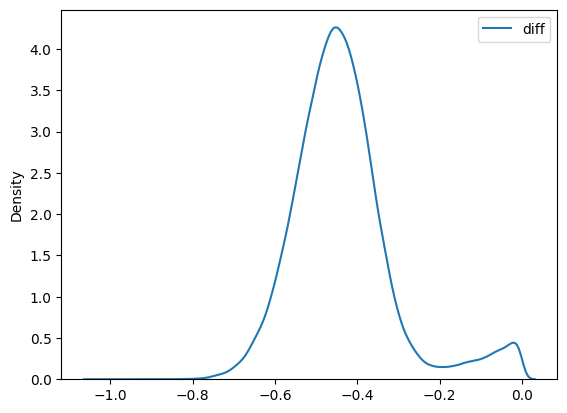

In [110]:
data = df[ df['diff'] < 0][['diff']]
# data = df[ df['diff'] < 0][['sim', 'org_sim', 'diff']]
sns.kdeplot(data)

Text(0.5, 1.0, 'Similarity score trends')

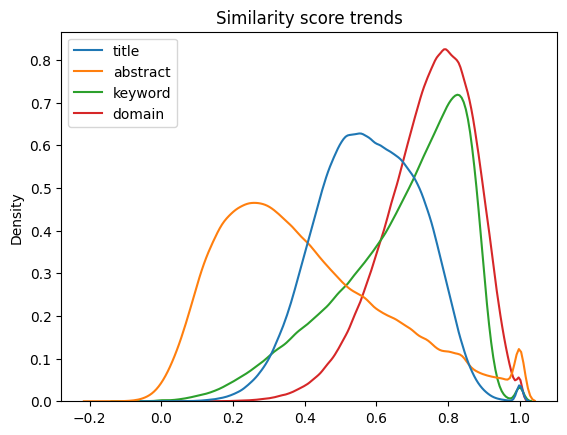

In [19]:
sns.kdeplot(similarity)
plt.title("Similarity score trends")

Text(0.5, 1.0, 'Total similarity score trends')

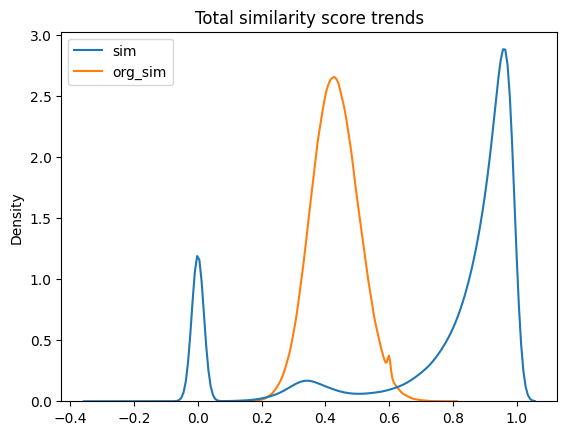

In [68]:
plot = df[['sim', 'org_sim']]
sns.kdeplot(plot)
plt.title('Total similarity score trends')

In [117]:
df = pd.read_csv(os.path.join(FILTERED_PATH, "trained_sim_undirected_100.csv"))
# out = torch.load(os.path.join(FILTERED_PATH,'result_undirected_100.pt'))
torch.arange(0, out.shape[0])[(out == 0).all(1)]

tensor([    19,     27,     30,  ..., 162204, 162205, 162206])

In [70]:
edges_df = pd.DataFrame(edges, columns=('src', 'dst'))
edges_df['src'] = edges_df['src'].apply(lambda x: id_to_int[x])
edges_df['dst'] = edges_df['dst'].apply(lambda x: id_to_int[x])

In [167]:
df['sim'] = edges_df.merge(df, on=['src', 'dst'])['sim']

NameError: name 'edges_df' is not defined

In [85]:
from dgl.nn import conv.GraphConv

In [166]:
similarity['src'] =similarity['src'].apply(lambda x: id_to_int[x])
similarity['dst'] =similarity['dst'].apply(lambda x: id_to_int[x])

In [168]:
df['org_sim'] = w1*similarity['title'] + w2*similarity['abstract'] + w3*similarity['keyword'] + w4*similarity['domain']

df['org_sim'] = 0.2*similarity['title'] + 0.2*similarity['abstract'] + 0.2*similarity['keyword'] + 0.4*(1-similarity['domain'])


In [169]:
df['diff'] = df['sim'] - df['org_sim']

df

,src,dst,sim,org_sim,diff
0,14961,42725,0.984479,0.467984,0.516495
1,33767,141985,0.930674,0.464085,0.466589
2,64675,132132,0.818782,0.317569,0.501214
3,102146,98155,0.786727,0.460876,0.325851
4,118623,112343,0.958769,0.475699,0.483070
...,...,...,...,...,...
1273170,69751,63337,0.966002,0.312897,0.653105
1273171,65311,59922,0.974722,0.336277,0.638445
1273172,156811,12704,0.313755,0.384613,-0.070857
1273173,155283,108435,0.737572,0.450320,0.287252


In [165]:
df = pd.read_csv(os.path.join(FILTERED_PATH, 'trained_sim.csv'))
# df = pd.read_csv('/lyceum/jhk1c21/msc_project/batch/loss_values.csv')


,src,dst,title,abstract,keyword,domain
0,53e99beab7602d9702497a80,53e9a4c0b7602d9702ddf482,0.470632,0.124602,0.634944,0.445128
1,53e9a1d5b7602d9702ad2aa6,558aec6284ae84d265c0707c,0.363818,0.738057,0.825033,0.803241
2,53e9abc9b7602d970357a86b,557d23366feeaa8086da70ff,0.549633,0.203248,0.594433,0.879736
3,53e9b708b7602d970429d764,53e9b5d4b7602d97041251f3,0.600002,0.239508,0.842274,0.688702
4,53e9bc1bb7602d9704883a9c,53e9ba39b7602d9704648483,0.568734,0.682352,0.832233,0.852411
...,...,...,...,...,...,...
1273170,53e9ad47b7602d970372c2bd,53e9ab6fb7602d970350e269,0.684507,0.129349,0.513802,0.881588
1273171,53e9abf1b7602d97035afe55,53e9aa79b7602d97033ef136,0.524307,0.402008,0.199441,0.722187
1273172,5a260c2e17c44a4ba8a24152,53e99b31b7602d97023ce813,0.499875,0.309166,0.822491,0.854233
1273173,599c77fa601a182cd2590dbc,53e9b903b7602d97044e594e,0.525179,0.415119,0.722028,0.705364


In [170]:
nodes[nodes['title'].str.contains('CONTRAfold: RNA secondary structure prediction without physics-based models')]

,title,keywords,abstract,fos
id,,,,
53e9a1f3b7602d9702af5839,CONTRAfold: RNA secondary structure prediction...,"['stochastic context free grammar', 'cross val...","Motivation: For several decades, free energy m...","[{'name': 'Rule-based machine translation', 'w..."


In [176]:
df.sort_values('diff')

,src,dst,sim,org_sim,diff
559292,41799,101349,0.000000,0.777639,-0.777639
529063,151864,33545,-0.143073,0.630573,-0.773646
432416,75077,98270,-0.276499,0.495920,-0.772419
998488,21174,68434,0.000000,0.759098,-0.759098
1033167,76872,25768,0.000000,0.752447,-0.752447
...,...,...,...,...,...
932195,133919,64671,0.986061,0.155952,0.830110
1068405,125953,30882,0.994377,0.164238,0.830139
1268642,43102,63374,0.973349,0.137508,0.835841
1239235,58934,67077,0.966044,0.129450,0.836595


In [185]:
src, dst = 58934, 67077
nodes.loc[[int_to_id[src], int_to_id[dst]]]

,title,keywords,abstract,fos
id,,,,
53e9aa24b7602d9703394980,Permutation test for periodicity in short time...,"['oscillations', 'random permutation', 'metabo...","Periodic processes, such as the circadian rhyt...","[{'name': 'Data point', 'w': 0.41985}, {'name'..."
53e9ac6ab7602d970363e436,Circadian Clocks Are Resounding In Peripheral ...,['t'],Circadian rhythms are prevalent in most organi...,"[{'name': 'Circadian rhythm', 'w': 0.57192}, {..."


In [188]:
similarity[(similarity['src'] == src) & (similarity['dst'] == dst)]

,src,dst,title,abstract,keyword,domain
1239235,58934,67077,0.33818,0.061343,0.019309,0.885791


In [41]:
node_features = np.concatenate([titles, abstracts, keywords, domains], axis=1)
tensor_node_features = torch.FloatTensor(node_features)

citation_network = dgl.graph((df['src'].to_numpy(), df['dst'].to_numpy()))
citation_network.ndata['features'] = torch.tensor(node_features, dtype=torch.float32)

In [43]:
def make_undirected(graph):    
    # Adding reverse edges to make the graph undirected
    src, dst = graph.edges()
    graph.add_edges(dst, src)
    
    return graph

citation_network = dgl.graph((df['src'].to_numpy(), df['dst'].to_numpy()))
citation_network = make_undirected(citation_network)
citation_network.ndata['features'] = torch.tensor(node_features, dtype=torch.float32)

(162207, 300)

In [87]:
from dgl import DGLGraph

In [22]:
out_undirected.

torch.Size([162207, 50])

In [121]:
df_undirected = pd.read_csv(os.path.join(FILTERED_PATH, "trained_sim_undirected_100.csv"))
df = pd.read_csv(os.path.join(FILTERED_PATH, "trained_sim.csv"))
df_1000 = pd.read_csv(os.path.join(FILTERED_PATH, "trained_sim_1000.csv"))
# out = torch.load(os.path.join(FILTERED_PATH,'result_undirected_100.pt'))
# torch.arange(0, out.shape[0])[(out == 0).all(1)]

Text(0.5, 1.0, 'directed')

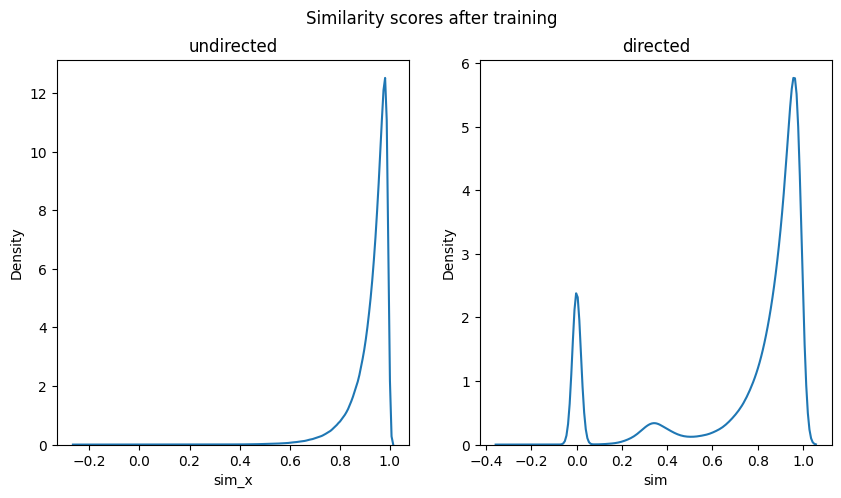

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
# fig.subtitle('Similarity scores trends after training')

sns.kdeplot(un['sim_x'], ax=axs[0])
fig.suptitle('Similarity score trends after training')
axs[0].set_title('undirected')
sns.kdeplot(df['sim'], ax=axs[1])
axs[1].set_title('directed')

Text(0.5, 1.0, 'Similarity score trends after training')

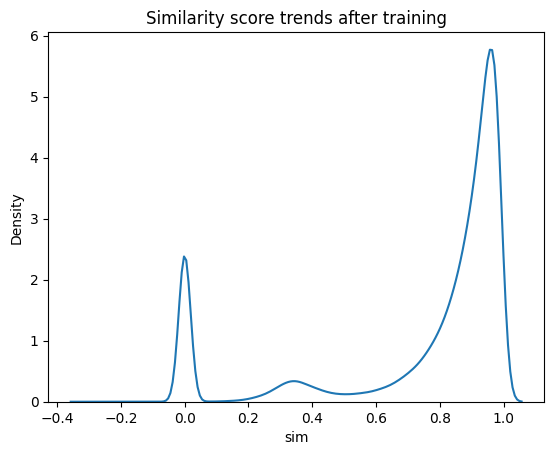

In [67]:
sns.kdeplot(df['sim'])
plt.title('Similarity score trends after training')

In [34]:
un = df_undirected.merge(df, on=['src', 'dst'], how='right')
un

,src,dst,sim_x,sim_y
0,14961,42725,0.979685,0.984479
1,33767,141985,0.863072,0.930674
2,64675,132132,0.887548,0.818782
3,102146,98155,0.835505,0.786727
4,118623,112343,0.966805,0.958769
...,...,...,...,...
1288731,69751,63337,0.931651,0.966002
1288732,65311,59922,0.978105,0.974722
1288733,156811,12704,0.927909,0.313755
1288734,155283,108435,0.902367,0.737572


In [81]:
w1, w2, w3, w4 = 0.2, 0.2, 0.2, 0.4
df['org_sim'] = w1*similarity['title'] + w2*similarity['abstract'] + w3*similarity['keyword'] + w4*similarity['domain']
un['org_sim'] = w1*similarity['title'] + w2*similarity['abstract'] + w3*similarity['keyword'] + w4*similarity['domain']
df_1000['org_sim'] = w1*similarity['title'] + w2*similarity['abstract'] + w3*similarity['keyword'] + w4*similarity['domain']

In [115]:
df['diff'] = df['sim'] - df['org_sim']
df_1000['diff'] = df_1000['sim'] - df_1000['org_sim']

In [93]:
df['diff'][(df['diff'] < 0)].shape[0]/df.shape[0]

0.20128968916291948

In [121]:
df[(df['diff'] > 0)].sort_values('diff', ascending=False)
# df_1000[(df_1000['diff'] > 0)].sort_values('diff', ascending=False)

,src,dst,sim,org_sim,diff
152668,102266,49694,0.981489,0.205964,7.755246e-01
836615,109965,49694,0.947942,0.201236,7.467055e-01
384072,34169,71860,0.957934,0.223899,7.340356e-01
1104478,42498,49694,0.982493,0.259533,7.229599e-01
765947,128937,94944,0.947471,0.227589,7.198817e-01
...,...,...,...,...,...
437104,132935,132935,1.000000,1.000000,1.110223e-16
133160,12088,12088,1.000000,1.000000,1.110223e-16
830349,44999,44999,1.000000,1.000000,1.110223e-16
675109,120,120,1.000000,1.000000,1.110223e-16


In [123]:
df['diff'][df['diff'] == 0]

14941      0.0
24420      0.0
30015      0.0
59250      0.0
66389      0.0
          ... 
1208436    0.0
1222025    0.0
1226828    0.0
1247120    0.0
1251612    0.0
Name: diff, Length: 210, dtype: float64

In [117]:
nodes.loc[[int_to_id[64907], int_to_id[112207]]]

,title,keywords,abstract,fos
id,,,,
53e9abd4b7602d970358e438,Related Key Differential Attacks on 27 Rounds ...,"['related key differential attack', 'distingui...","In this paper, we present a related key trunca...","[{'name': 'XTEA', 'w': 0.65178}, {'name': 'Mas..."
53e9ba2db7602d970463a933,"Key-Schedule Cryptoanalysis of IDEA, G-DES, GO...","['new athcks', 'actual protocol', 'related-key...",We present new athcks on key schedules of bloc...,"[{'name': 'Symmetric-key algorithm', 'w': 0.58..."


In [118]:
nodes.loc[[int_to_id[30565], int_to_id[976]]]

,title,keywords,abstract,fos
id,,,,
53e9a0d1b7602d97029b7a9e,Selection of relevant features and examples in...,['machine learning'],"In this survey, we review work in machine lear...","[{'name': 'Data set', 'w': 0.41913}, {'name': ..."
53e99803b7602d9702012b2f,Greedy Attribute Selection,"['hill climbing', 'attribute selection']",Many real-world domains bless us with a wealth...,"[{'name': 'Feature selection', 'w': 0.52676}, ..."


In [119]:
nodes.loc[[int_to_id[34558], int_to_id[2345]]]

,title,keywords,abstract,fos
id,,,,
53e9a216b7602d9702b16d5f,"Dyn-FO: a parallel, dynamic complexity class","['dynamic complexity class', 'computational co...","Traditionally, computational complexity has co...","[{'name': 'PH', 'w': 0.52817}, {'name': 'Compl..."
53e99845b7602d9702072ace,Maintaining views incrementally,['materialized views'],We present incremental evaluation algorithms t...,"[{'name': 'SQL', 'w': 0.49327}, {'name': 'Subs..."


In [129]:
df[ (df['diff'] < 0.001) & (df['diff'] > -0.001) & (df['diff'] == 0) ].sort_values('diff')
# 200949/df.shape[0]

,src,dst,sim,org_sim,diff
1175799,59481,59481,1.0,1.0,0.0
1183335,35571,35571,1.0,1.0,0.0
1191371,44048,44048,1.0,1.0,0.0
1204493,36362,36362,1.0,1.0,0.0
1208150,95625,95625,1.0,1.0,0.0
...,...,...,...,...,...
109546,131684,131684,1.0,1.0,0.0
110933,33542,33542,1.0,1.0,0.0
111604,99036,99036,1.0,1.0,0.0
1251612,5021,5021,1.0,1.0,0.0


In [125]:
df[df['sim'] == 0]

,src,dst,sim,org_sim,diff
7,42460,17284,0.0,0.494019,-0.494019
12,159479,143772,0.0,0.568703,-0.568703
18,158401,146017,0.0,0.599919,-0.599919
21,157602,152079,0.0,0.572972,-0.572972
30,118847,123771,0.0,0.675775,-0.675775
...,...,...,...,...,...
1273136,151746,121777,0.0,0.740395,-0.740395
1273144,126524,44041,0.0,0.707552,-0.707552
1273152,153432,84372,0.0,0.609228,-0.609228
1273155,17775,7765,0.0,0.658067,-0.658067


In [18]:
df[df['sim'] == 0]

,src,dst,sim
7,42460,17284,0.0
12,159479,143772,0.0
18,158401,146017,0.0
21,157602,152079,0.0
30,118847,123771,0.0
...,...,...,...
1273136,151746,121777,0.0
1273144,126524,44041,0.0
1273152,153432,84372,0.0
1273155,17775,7765,0.0


In [48]:
zeros = out.all(dim=1)
print(np.where(zeros == 0)[0].shape[0], np.where(zeros == 0)[0])

20777 [    19     27     30 ... 162204 162205 162206]


In [40]:
out[19]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<SelectBackward0>)

In [45]:
citation_network.in_degrees(162206)

0

In [49]:
dddf_200 = pd.read_csv('/lyceum/jhk1c21/msc_project/data/graph/filtered/n_citation/node_200.csv')
dddf_50 = pd.read_csv('/lyceum/jhk1c21/msc_project/data/graph/filtered/n_citation/node_50.csv')

In [50]:
dddf_200

,_id,title,keywords,fos,abstract
0,53e997bab7602d9701fa09cb,PLEdestrians: a least-effort approach to crowd...,"['biomechanically energy-efficient', 'large-sc...","['Crowds', 'Pedestrian', 'Random forcing', 'Pr...",We present a new algorithm for simulating larg...
1,53e997cbb7602d9701fbd3d4,Tensor Discriminative Locality Alignment for H...,"['geophysical techniques', 'remote sensing', '...","['Computer vision', 'Imaging spectrometer', 'D...","In this paper, we propose a method for the dim..."
2,53e997cbb7602d9701fbd7cb,Current State of the Art in Distributed Autnom...,['mobile robot'],"['Robot learning', 'Open research', 'Social ro...",. As research progresses in distributed robot...
3,53e997ccb7602d9701fbec69,Towards a Conceptual Framework for Resilience ...,"['business continuity', 'organisational aspect...","['Psychological resilience', 'Computer securit...",This publication contains reprint articles for...
4,53e997ccb7602d9701fbec7a,Trust-Aware Collaborative Filtering for Recomm...,"['collaborative filtering', 'web of trust', 'r...","['Current user', 'Recommender system', 'World ...",Recommender Systems allow people to find the r...
...,...,...,...,...,...
61223,5d20756c275ded87f951cfdd,Salient object detection: A survey.,"['salient object detection', ' saliency', ' vi...","['Computer vision', 'Market segmentation', 'Sa...",Detecting and segmenting salient objects from ...
61224,599c78a4601a182cd25e0788,Mixed Membership Stochastic Blockmodels.,"['hierarchical Bayes', 'latent variables', 'me...","['Pairwise comparison', 'Protein Interaction N...",Consider data consisting of pairwise measureme...
61225,599c786c601a182cd25c5be2,Veriflow: verifying network-wide invariants in...,"['Algorithms', 'Design', 'Experimentation', 'M...","['Route Views', 'Control theory', 'Computer sc...",Networks are complex and prone to hugs. Existi...
61226,599c7a59601a182cd26ac280,Backtracking algorithms for disjunctions of te...,"['temporal reasoning', 'constraint satisfactio...","['Discrete mathematics', 'Local consistency', ...",We extend the framework of simple temporal pro...


In [51]:
dddf_50

,_id,title,keywords,fos,abstract
0,53e99792b7602d9701f5af35,An approach to feature location in distributed...,"['Feature location', 'Distributed systems', 'S...","['Data mining', 'Causality', 'End user', 'Rank...",This paper describes an approach to the featur...
1,53e99792b7602d9701f5b119,A fuzzy multi-objective programming for optimi...,"['Location', 'Fire stations', 'Multi-objective...","['Objective programming', 'Fire protection', '...",Location of fire stations is an important fact...
2,53e99792b7602d9701f5b19a,Testing the stability of the functional autore...,"['asymptotic justification', 'observations x',...","['Functional principal component analysis', 'T...",The functional autoregressive process has beco...
3,53e99792b7602d9701f5b2a1,On Efficient Fixed Parameter Algorithms for WE...,"['weight function', 'vertex cover', 'combinato...","['Integer', 'Weight function', 'Edge cover', '...",We investigate the fixed parameter complexity ...
4,53e99792b7602d9701f5b2c7,A stepwise framework for the normalization of ...,"['microarrays', 'copy number', 'genetic variat...","['CDNA Arrays', 'Normalization (statistics)', ...",In two-channel competitive genomic hybridizati...
...,...,...,...,...,...
316439,5fae652cd4150a363cdc8748,Asynchronous Code-Division Random Access Using...,"['Asynchronous random access', 'Lasso', 'Match...","['Asynchronous communication', 'Computer scien...",Many applications in cellular systems and sens...
316440,5fe035f29e795ea5d94fd49b,Early Prediction of Sepsis from Clinical Data:...,"['Sepsis', 'Medicine', 'Cardiology', 'Demograp...","['Sequence prediction', 'Early detection', 'Ti...",The PhysioNet/Computing in Cardiology Challeng...
316441,5ff2e790d4150a363cfd7437,Neural Abstractive Text Summarization with Seq...,"['Abstractive text summarization', 'attention ...","['Automatic summarization', 'Computer science'...","In the past few years, neural abstractive text..."
316442,5ff68bd5d4150a363cd0875a,A review on locomotion robophysics: the study ...,"['robotics', 'soft matter', 'dynamical systems']","['Geometric mechanics', 'Open air', 'Terrain',...",Discovery of fundamental principles which gove...


In [52]:
eee_200 = np.load('/lyceum/jhk1c21/msc_project/data/graph/filtered/n_citation/edge_list_200.npy')
eee_50 = np.load('/lyceum/jhk1c21/msc_project/data/graph/filtered/n_citation/edge_list_50.npy')

In [53]:
eee_200.shape

(567092, 2)

In [54]:
eee_50.shape

(3759567, 2)